# Lab Group: FSP6

## Dataset: Alpha Vantage Stock APIs , YahooFinance

Problem Statement: 
1. To what extent is the price of Bitcoin dependent on the global financial system that is represented through stock indices?
2. Which is the more accurate model in predicting bitcoin prices, Autoregression or Long Short Term Memory?

Group Members: Ingale Omkar, Lau Chen Yi Wynne, Himari Ang Lixin

### Data Extraction and Data Cleaning

In [1]:
# Importing essential libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import math
import datetime

# Importing libraries needed for auto regression
from pandas.plotting import lag_plot,autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error

# importing libraries needed for VAR
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

# importing libraries needed for LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies

In [3]:
# This is used to download BTC data from AlphaVantage
crypt = CryptoCurrencies('WQ8W67GO6PP73AD4', output_format = 'pandas')

In [4]:
# Extract BTC data from AlphaVantage
btc_av = crypt.get_digital_currency_daily('BTC', market='USD')[0]
btc_av = pd.DataFrame(btc_av)
btc_av = btc_av['2021-03-24':]
btc_av

,1a. open (USD),1b. open (USD),2a. high (USD),2b. high (USD),3a. low (USD),3b. low (USD),4a. close (USD),4b. close (USD),5. volume,6. market cap (USD)
date,,,,,,,,,,
2021-03-24,54342.80,54342.80,57200.00,57200.00,51700.00,51700.00,52303.65,52303.65,83537.465021,83537.465021
2021-03-23,54083.25,54083.25,55830.90,55830.90,53000.00,53000.00,54340.89,54340.89,59789.365427,59789.365427
2021-03-22,57351.56,57351.56,58430.73,58430.73,53650.00,53650.00,54083.25,54083.25,62581.626169,62581.626169
2021-03-21,58100.02,58100.02,58589.10,58589.10,55450.11,55450.11,57351.56,57351.56,48564.470274,48564.470274
2021-03-20,58030.01,58030.01,59880.00,59880.00,57820.17,57820.17,58102.28,58102.28,44476.941776,44476.941776
...,...,...,...,...,...,...,...,...,...,...
2018-08-01,7735.67,7735.67,7750.00,7750.00,7430.00,7430.00,7604.58,7604.58,42582.312932,42582.312932
2018-07-31,8171.40,8171.40,8180.00,8180.00,7633.00,7633.00,7730.93,7730.93,48296.915587,48296.915587
2018-07-30,8210.99,8210.99,8273.00,8273.00,7866.00,7866.00,8173.92,8173.92,39692.416542,39692.416542


In [5]:
# Keep the BTC data for "close (USD)"
btc_av = btc_av[['4a. close (USD)']]

# Rename the header names
btc_av.columns = ['Close']
btc_av.index.names = ['Date']

# Make sure data is in ascending order (oldest to latest)
btc_av = btc_av.iloc[::-1]
btc_av

,Close
Date,
2018-07-28,8225.04
2018-07-29,8211.00
2018-07-30,8173.92
2018-07-31,7730.93
2018-08-01,7604.58
...,...
2021-03-20,58102.28
2021-03-21,57351.56
2021-03-22,54083.25


In [6]:
end_date = btc_av.index[0].date()
days = datetime.timedelta(1)
end_date = end_date - days
print("Extract prices till :", end_date)

Extract prices till : 2018-07-27


In [7]:
# Download BTC data from Yahoo Finance 
btc_yf = yf.download('BTC-USD', end = end_date)
btc_yf

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2018-07-23,7414.709961,7771.500000,7409.100098,7711.109863,7711.109863,5132480000
2018-07-24,7716.509766,8424.269531,7705.500000,8424.269531,8424.269531,7277689856
2018-07-25,8379.660156,8416.870117,8086.359863,8181.390137,8181.390137,5845400064


In [8]:
# Keep the BTC data for "Close" by dropping the other columns
btc_yf = btc_yf.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1)
btc_yf

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2018-07-23,7711.109863
2018-07-24,8424.269531
2018-07-25,8181.390137


In [9]:
# Combine the two data sets (from Alpha Vantage and Yahoo Finance)
BTC = pd.concat([btc_yf, btc_av])
BTC

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-03-20,58102.280000
2021-03-21,57351.560000
2021-03-22,54083.250000


In [10]:
main_start = BTC.index[0].date()
main_end = BTC.index[-1].date()
print("Startd date: \t", main_start)
print("End date: \t", main_end)

Startd date: 	 2014-09-17
End date: 	 2021-03-24


The data for all the other factors can now be collected using the yahoo finance api. This has to be done between the dates that were used for the BTC dataframe.  
The data will be collected for: 
- S&P500 index ('^GSPC') 
- Dow Jones Industrial Average ('^DJI')
- NASDAQ Composite ('^IXIC')
- NYSE COMPOSITE ('^NYA')
- Nikkei ('^N225')
- S&P BSE SENSEX ('^BSESN')
- S&P/ASX 200 ('^AXJO') 
- NIFTY 50 ('^NSEI')
- S&P/TSX Composite index ('^GSPTSE')
- KOSPI Composite Index (^KS11)

In [11]:
# Download other indices that could affect BTC
indices = yf.download(['^GSPC','^DJI','^IXIC','^NYA','^N225','^BSESN','^AXJO',
                       '^NSEI','^GSPTSE','^KS11'], 
                      start=main_start, end=main_end)

# Keep the indices data for "Close"
indices = indices['Close']
indices

[*********************100%***********************]  10 of 10 completed


,^AXJO,^BSESN,^DJI,^GSPC,^GSPTSE,^IXIC,^KS11,^N225,^NSEI,^NYA
Date,,,,,,,,,,
2014-09-17,5407.299805,26631.289062,17156.849609,2001.569946,15458.900391,4562.189941,2062.610107,15888.669922,7975.500000,10973.740234
2014-09-18,5415.799805,27112.210938,17265.990234,2011.359985,15465.500000,4593.430176,2047.739990,16067.570312,8114.750000,11024.059570
2014-09-19,5433.100098,27090.419922,17279.740234,2010.400024,15265.400391,4579.790039,2053.820068,16321.169922,8121.450195,10989.570312
2014-09-22,5363.000000,27206.740234,17172.679688,1994.290039,15129.000000,4527.689941,2039.270020,16205.900391,8146.299805,10892.639648
2014-09-23,5415.700195,26775.689453,17055.869141,1982.770020,15125.700195,4508.689941,2028.910034,NaN,8017.549805,10815.419922
...,...,...,...,...,...,...,...,...,...,...
2021-03-18,6745.899902,49216.519531,32862.300781,3915.459961,18836.500000,13116.169922,3066.010010,30216.750000,14557.849609,15589.089844
2021-03-19,6708.200195,49858.238281,32627.970703,3913.100098,18854.000000,13215.240234,3039.530029,29792.050781,14744.000000,15562.299805
2021-03-22,6752.500000,49771.289062,32731.199219,3940.590088,18815.099609,13377.540039,3035.459961,29174.150391,14736.400391,15551.559570


In [12]:
# Combine the BTC data with the other indices
combined = pd.concat([BTC,indices], join='inner', axis=1)
combined.columns = ['Bitcoin','^AXJO','^BSESN','^DJI','^GSPC','^GSPTSE','^IXIC',
                    '^KS11','^N225','^NSEI','^NYA']
combined

,Bitcoin,^AXJO,^BSESN,^DJI,^GSPC,^GSPTSE,^IXIC,^KS11,^N225,^NSEI,^NYA
Date,,,,,,,,,,,
2014-09-17,457.334015,5407.299805,26631.289062,17156.849609,2001.569946,15458.900391,4562.189941,2062.610107,15888.669922,7975.500000,10973.740234
2014-09-18,424.440002,5415.799805,27112.210938,17265.990234,2011.359985,15465.500000,4593.430176,2047.739990,16067.570312,8114.750000,11024.059570
2014-09-19,394.795990,5433.100098,27090.419922,17279.740234,2010.400024,15265.400391,4579.790039,2053.820068,16321.169922,8121.450195,10989.570312
2014-09-22,402.152008,5363.000000,27206.740234,17172.679688,1994.290039,15129.000000,4527.689941,2039.270020,16205.900391,8146.299805,10892.639648
2014-09-23,435.790985,5415.700195,26775.689453,17055.869141,1982.770020,15125.700195,4508.689941,2028.910034,NaN,8017.549805,10815.419922
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-18,57648.160000,6745.899902,49216.519531,32862.300781,3915.459961,18836.500000,13116.169922,3066.010010,30216.750000,14557.849609,15589.089844
2021-03-19,58030.010000,6708.200195,49858.238281,32627.970703,3913.100098,18854.000000,13215.240234,3039.530029,29792.050781,14744.000000,15562.299805
2021-03-22,54083.250000,6752.500000,49771.289062,32731.199219,3940.590088,18815.099609,13377.540039,3035.459961,29174.150391,14736.400391,15551.559570


#### Using correlation (heatmap) to choose stock indices

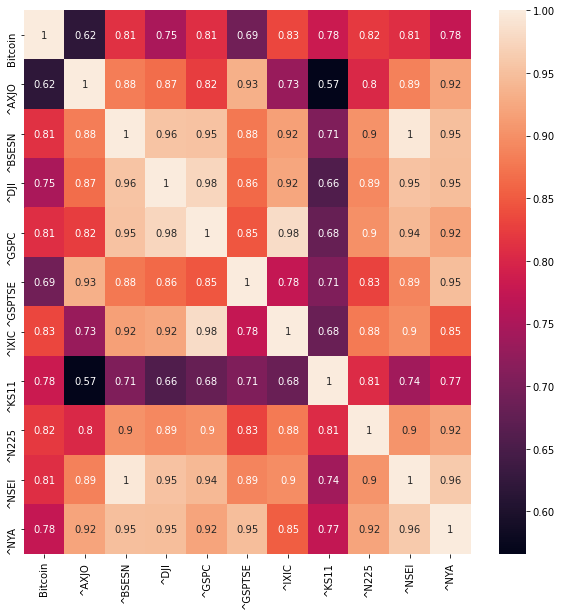

In [13]:
# Plot the heat map to find out which indices have a high correlation with BTC
plt.figure(figsize = (10,10))
matrix = combined.corr()
sb.heatmap(combined.corr(), annot=True)

In [14]:
matrix

,Bitcoin,^AXJO,^BSESN,^DJI,^GSPC,^GSPTSE,^IXIC,^KS11,^N225,^NSEI,^NYA
Bitcoin,1.000000,0.619197,0.813158,0.748851,0.808653,0.693127,0.833397,0.781594,0.821135,0.809588,0.775089
^AXJO,0.619197,1.000000,0.882750,0.866575,0.824375,0.933574,0.731985,0.566109,0.802240,0.886049,0.920892
^BSESN,0.813158,0.882750,1.000000,0.955786,0.953897,0.877647,0.915282,0.705391,0.902109,0.996211,0.950415
^DJI,0.748851,0.866575,0.955786,1.000000,0.975965,0.864289,0.922301,0.656528,0.893055,0.953938,0.948721
^GSPC,0.808653,0.824375,0.953897,0.975965,1.000000,0.846802,0.981770,0.680402,0.900056,0.942548,0.921047
^GSPTSE,0.693127,0.933574,0.877647,0.864289,0.846802,1.000000,0.775879,0.705832,0.830336,0.889380,0.948926
^IXIC,0.833397,0.731985,0.915282,0.922301,0.981770,0.775879,1.000000,0.683812,0.878728,0.897121,0.853213
^KS11,0.781594,0.566109,0.705391,0.656528,0.680402,0.705832,0.683812,1.000000,0.805260,0.739446,0.773574
^N225,0.821135,0.802240,0.902109,0.893055,0.900056,0.830336,0.878728,0.805260,1.000000,0.904650,0.920433
^NSEI,0.809588,0.886049,0.996211,0.953938,0.942548,0.889380,0.897121,0.739446,0.904650,1.000000,0.961208


In [15]:
# Print out the indices that has a high correlation of 0.8 and above with BTC
for i in range(10):
    if (matrix.iloc[0][i] >= 0.8) and (matrix.iloc[0][i] != 1):
        print(matrix.columns[i])

^BSESN
^GSPC
^IXIC
^N225
^NSEI


#### The indices that have a correlation of above 0.8 are  
1) BSESN  
2) GSPC  
3) IXIC  
4) N225  
5) NSEI  

In [16]:
# Keep the indices that have a high correlation with BTC 
combined = combined.drop(columns = ['^AXJO','^DJI','^GSPTSE','^NYA','^KS11'])
combined

,Bitcoin,^BSESN,^GSPC,^IXIC,^N225,^NSEI
Date,,,,,,
2014-09-17,457.334015,26631.289062,2001.569946,4562.189941,15888.669922,7975.500000
2014-09-18,424.440002,27112.210938,2011.359985,4593.430176,16067.570312,8114.750000
2014-09-19,394.795990,27090.419922,2010.400024,4579.790039,16321.169922,8121.450195
2014-09-22,402.152008,27206.740234,1994.290039,4527.689941,16205.900391,8146.299805
2014-09-23,435.790985,26775.689453,1982.770020,4508.689941,NaN,8017.549805
...,...,...,...,...,...,...
2021-03-18,57648.160000,49216.519531,3915.459961,13116.169922,30216.750000,14557.849609
2021-03-19,58030.010000,49858.238281,3913.100098,13215.240234,29792.050781,14744.000000
2021-03-22,54083.250000,49771.289062,3940.590088,13377.540039,29174.150391,14736.400391


In [17]:
# Clean the data frame here by dropping rows with value "NaN"
combined = combined.dropna()
combined

,Bitcoin,^BSESN,^GSPC,^IXIC,^N225,^NSEI
Date,,,,,,
2014-09-17,457.334015,26631.289062,2001.569946,4562.189941,15888.669922,7975.500000
2014-09-18,424.440002,27112.210938,2011.359985,4593.430176,16067.570312,8114.750000
2014-09-19,394.795990,27090.419922,2010.400024,4579.790039,16321.169922,8121.450195
2014-09-22,402.152008,27206.740234,1994.290039,4527.689941,16205.900391,8146.299805
2014-09-24,423.204987,26744.689453,1998.300049,4555.220215,16167.450195,8002.399902
...,...,...,...,...,...,...
2021-03-17,58912.970000,49801.621094,3974.120117,13525.200195,29914.330078,14721.299805
2021-03-18,57648.160000,49216.519531,3915.459961,13116.169922,30216.750000,14557.849609
2021-03-19,58030.010000,49858.238281,3913.100098,13215.240234,29792.050781,14744.000000


## Basic Exploratory Analysis

#### Box plot, Histogram and Violin plot

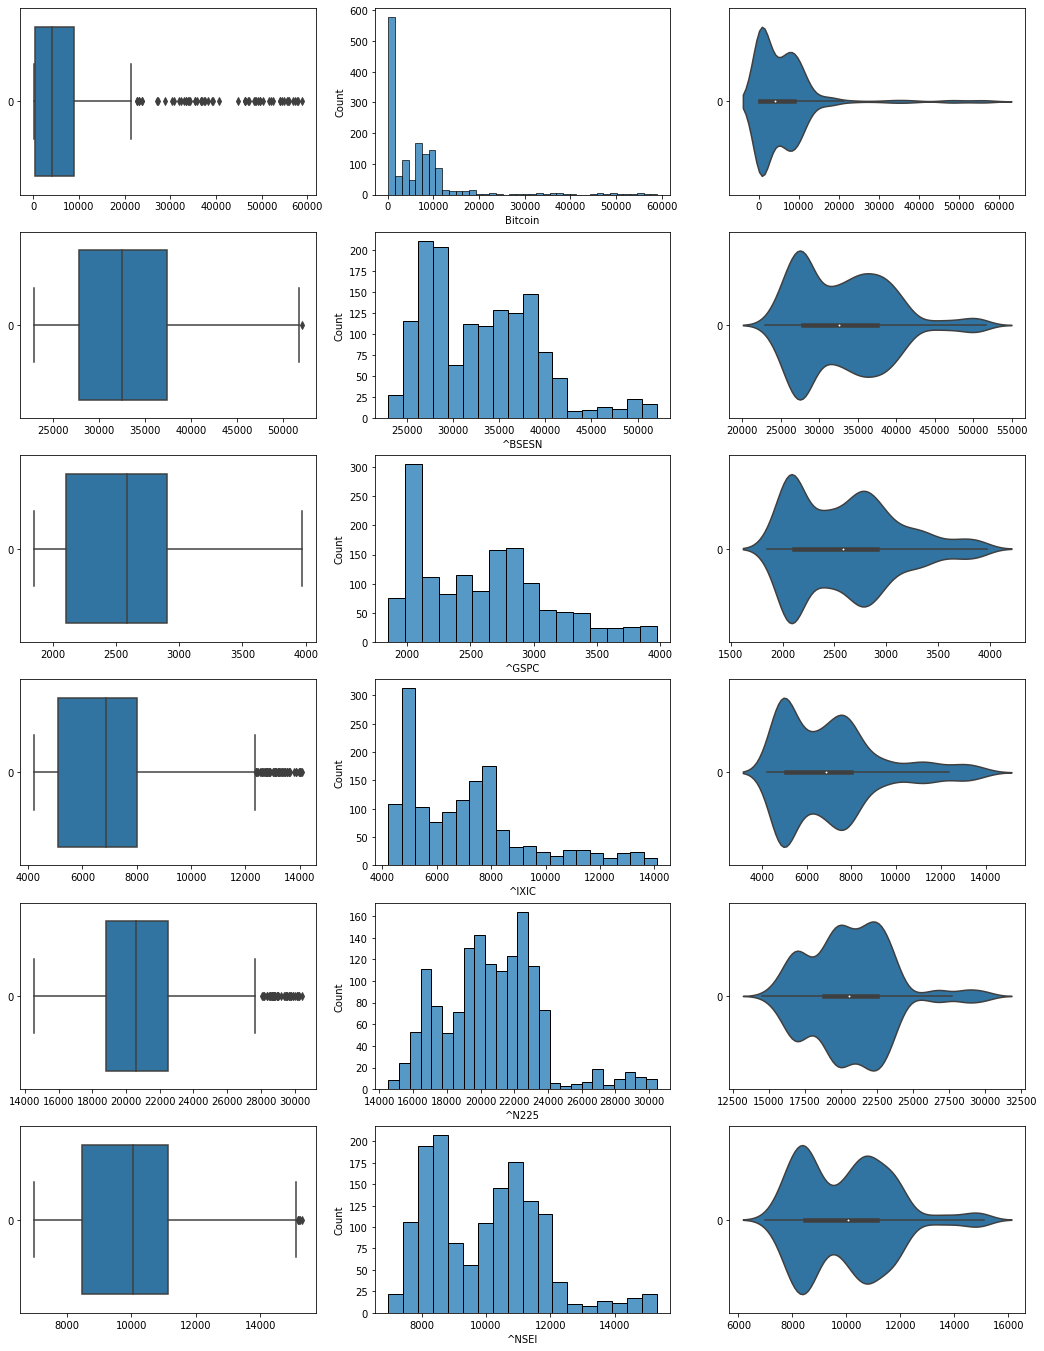

In [18]:
# Draw the distributions of all variables
f, axes = plt.subplots(6, 3, figsize=(18, 24))

# Plot the box plot, histogram and violin plot of the variables (including BTC)
count = 0
for var in combined:
    sb.boxplot(data = combined[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = combined[var], ax = axes[count,1])
    sb.violinplot(data = combined[var], orient = "h", ax = axes[count,2])
    count += 1

#### Pair plot

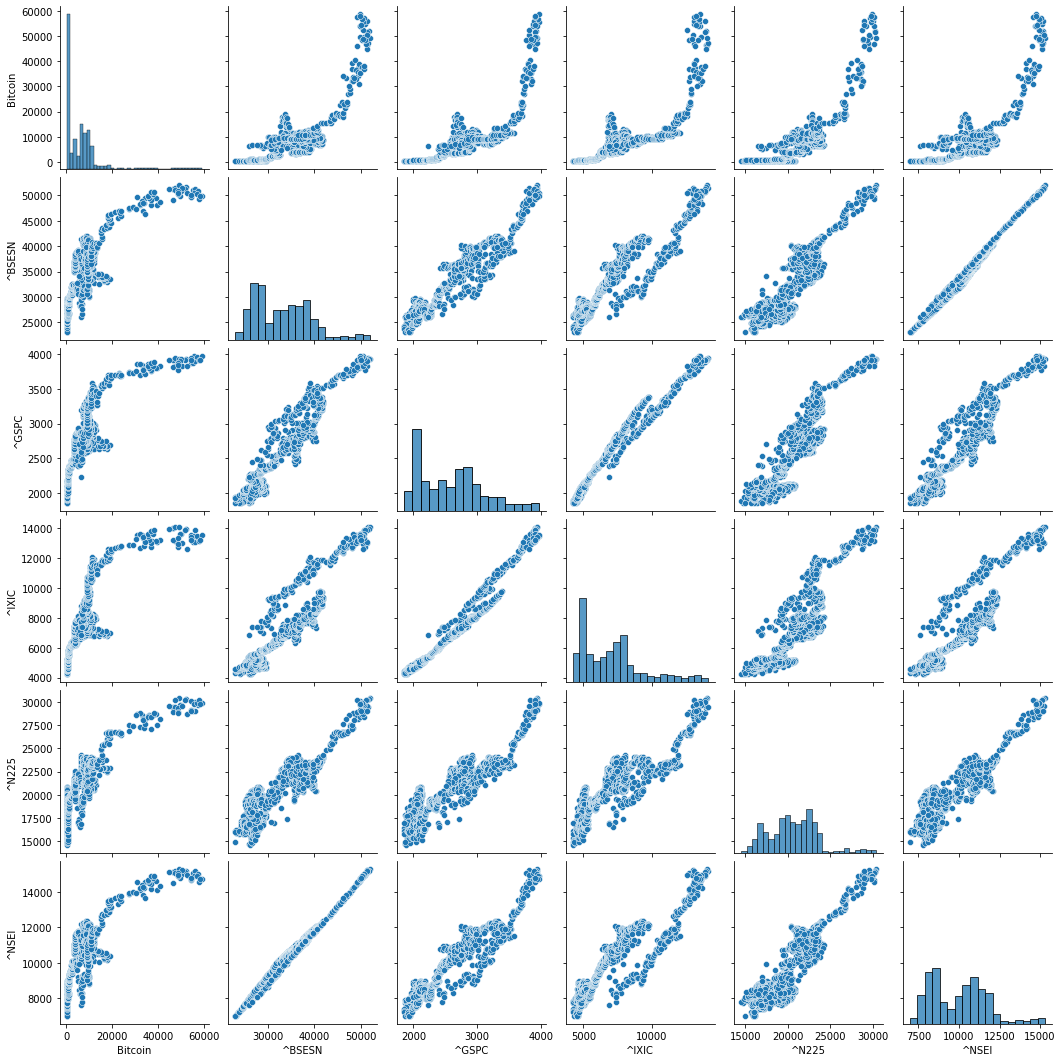

In [19]:
# Plot the pair plot 
sb.pairplot(data=combined)

#### Heatmap

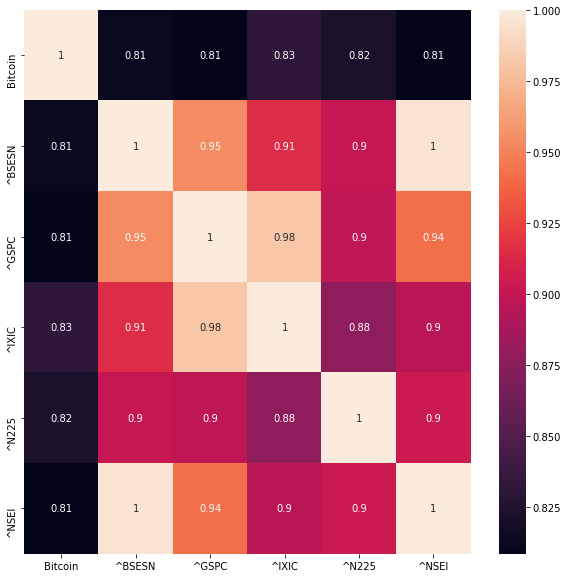

In [20]:
# Plot the heatmap
plt.figure(figsize = (10,10))
matrix = combined.corr()
sb.heatmap(combined.corr(), annot=True)

In [21]:
# This function is to gauge the accuracy of all predicted values
def accuracy(df):
    total = 0
    actual_values = df.iloc[:,0]
    predicted = df.iloc[:,1]
    for i in range(0, len(df)):
        print('Actual Value: $', actual_values[i], ' Predicted Value: $', 
              predicted[i], ' Accuracy: ', (predicted[i]/actual_values[i])*100)
        total += (predicted[i]/actual_values[i])*100
    average = total/len(df)
    print('Average Accuracy over 7 Days: ',average)

# This function is to calculate the residual forecast error and mean forecast 
# error
def RFE(df):
    forecast = []
    actual_values = df.iloc[:,0]
    predicted = df.iloc[:,1]
    for i in range(0, len(df)):
        difference = actual_values[i]-predicted[i]
        forecast.append(difference)
    print(forecast)
    bias = sum(forecast) * 1.0/len(df)
    print('Mean Forecast Error: %f' % bias)

## Autocorrelation and Autoregression on Bitcoin

In [22]:
# Extract BTC data
BTC = pd.DataFrame(combined['Bitcoin'])
BTC

,Bitcoin
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-22,402.152008
2014-09-24,423.204987
...,...
2021-03-17,58912.970000
2021-03-18,57648.160000
2021-03-19,58030.010000


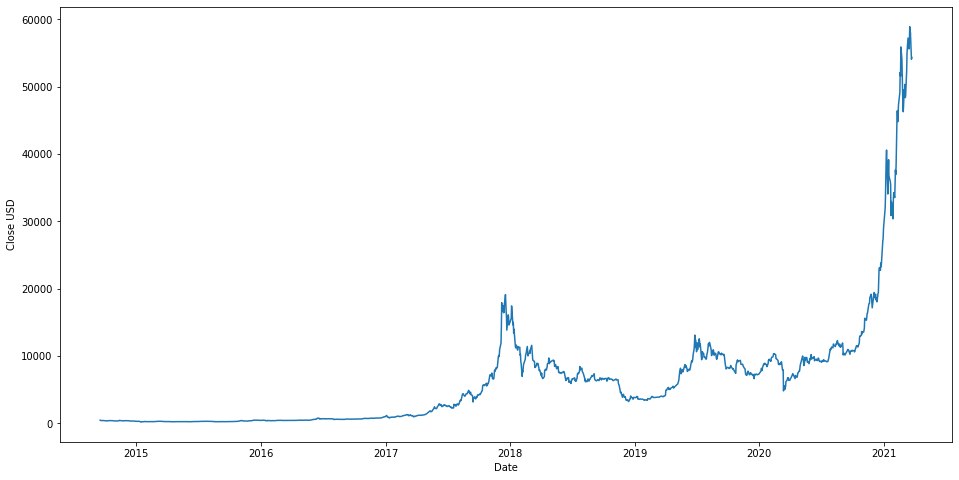

In [23]:
# Plot the time series of BTC
plt.figure(figsize = (16,8))
plt.plot(combined['Bitcoin'])
plt.xlabel('Date')
plt.ylabel('Close USD')
plt.show()

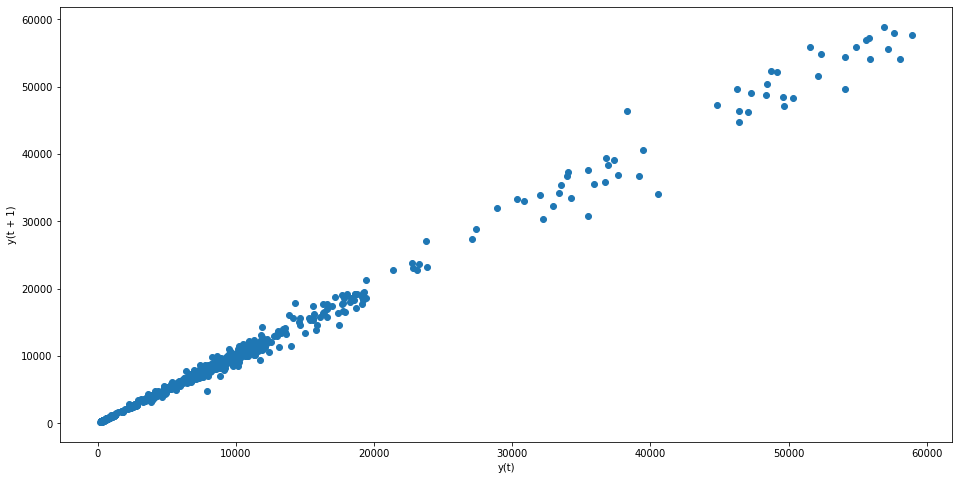

In [24]:
# Plot lag plot of BTC to determine if the values of BTC are random
plt.figure(figsize = (16,8))
lag_plot(BTC)

In [25]:
BTC_corr = pd.concat([BTC.shift(1),BTC], axis = 1)
BTC_corr.columns=['t-1','t+1']
BTC_corr.corr(method='pearson')

,t-1,t+1
t-1,1.000000,0.997532
t+1,0.997532,1.000000


In [26]:
X = BTC.values
test_size = 7
train, test = X[1:len(X)-test_size],X[len(X)-test_size:]

In [27]:
print(train.shape)
print(test.shape)

(1448, 1)
(7, 1)


In [28]:
# Fit to a UAR model
model = AR(train)
model_fit= model.fit()

In [29]:
variables = model_fit.k_ar 
coefficients = model_fit.params 

In [30]:
historical_data = train[len(train) - variables:]
historical_data

array([[36936.66],
       [38290.24],
       [46374.87],
       [46420.42],
       [44807.58],
       [47287.6 ],
       [49133.45],
       [52119.71],
       [51552.6 ],
       [55906.  ],
       [54087.67],
       [49676.2 ],
       [47073.73],
       [46276.87],
       [49587.03],
       [48440.65],
       [50349.37],
       [48374.09],
       [48751.71],
       [52375.17],
       [54884.5 ],
       [55851.59],
       [57221.72]])

In [31]:
historical_data = [historical_data[i] for i in range(len(historical_data))]
historical_data

[array([36936.66]),
 array([38290.24]),
 array([46374.87]),
 array([46420.42]),
 array([44807.58]),
 array([47287.6]),
 array([49133.45]),
 array([52119.71]),
 array([51552.6]),
 array([55906.]),
 array([54087.67]),
 array([49676.2]),
 array([47073.73]),
 array([46276.87]),
 array([49587.03]),
 array([48440.65]),
 array([50349.37]),
 array([48374.09]),
 array([48751.71]),
 array([52375.17]),
 array([54884.5]),
 array([55851.59]),
 array([57221.72])]

In [32]:
# Predict the values of BTC and store them in an array
predicted = []

for t in test:
    length = len(historical_data)
    lag = [historical_data[i] for i in range(length - variables, length)]
    y = coefficients[0]
    for d in range(variables):       
        y += coefficients[d + 1] * lag[variables - d - 1]
    predicted.append(y)
    historical_data.append(t)

In [33]:
# RMSE of the Univariate autoregression
UAR_rmse = math.sqrt(mean_squared_error(test,predicted))
print("Root mean squared error for Uni-variate autoregression: $", UAR_rmse)

Root mean squared error for Uni-variate autoregression: $ 2887.6325006673856


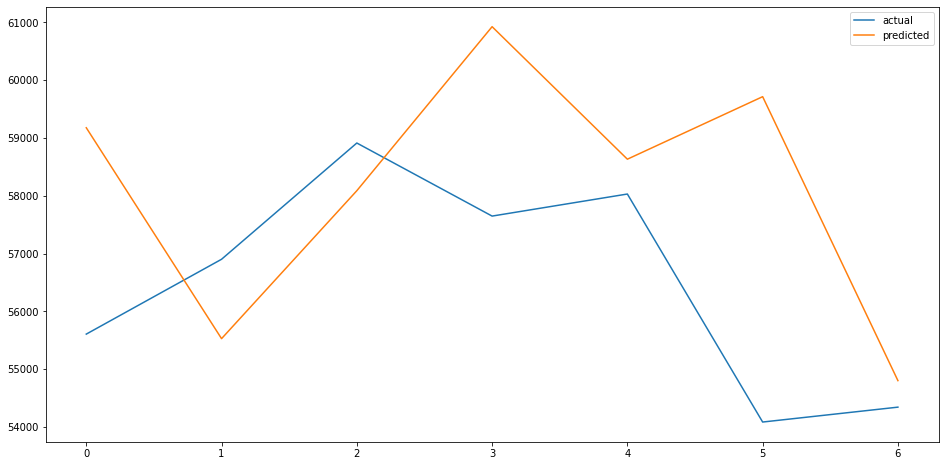

In [34]:
# Plot the Univariate autoregression with the actual values of BTC
f = plt.figure(figsize=(16, 8))
plt.plot(test,label='actual')
plt.plot(predicted,label='predicted')
plt.legend()

In [35]:
# Printing the accuracy for all the test dates.
test = pd.DataFrame(test)
predicted = pd.DataFrame(predicted)
combined_UAR = pd.concat([test, predicted], axis = 1)
accuracy(combined_UAR)

Actual Value: $ 55605.2  Predicted Value: $ 59177.147440611436  Accuracy:  106.42376511659239
Actual Value: $ 56900.75  Predicted Value: $ 55526.7975435793  Accuracy:  97.58535264223987
Actual Value: $ 58912.97  Predicted Value: $ 58087.574980603575  Accuracy:  98.59895873625717
Actual Value: $ 57648.16  Predicted Value: $ 60926.6208182039  Accuracy:  105.68701727549308
Actual Value: $ 58030.01  Predicted Value: $ 58633.01445621121  Accuracy:  101.03912519782645
Actual Value: $ 54083.25  Predicted Value: $ 59715.15812162843  Accuracy:  110.41340548437535
Actual Value: $ 54340.89  Predicted Value: $ 54800.03115712002  Accuracy:  100.84492756213604
Average Accuracy over 7 Days:  102.94179314498862


In [36]:
#printing the forcasted error.
RFE(combined_UAR)

[-3571.9474406114387, 1373.9524564207022, 825.3950193964265, -3278.4608182038937, -603.0044562112089, -5631.908121628432, -459.1411571200224]
Mean Forecast Error: -1620.730645


In [37]:
# Saving the predicted data frame for future analysis 
UAR_pred = pd.DataFrame(index=combined['Bitcoin'].tail(7).index)
predicted.index = combined['Bitcoin'].tail(7).index
UAR_pred['predicted'] = predicted
UAR_pred

,predicted
Date,
2021-03-15,59177.147441
2021-03-16,55526.797544
2021-03-17,58087.574981
2021-03-18,60926.620818
2021-03-19,58633.014456
2021-03-22,59715.158122
2021-03-23,54800.031157


## Multi-Variate Vector AutoRegression

Response Variable: BTC  
Predictor Feature:  
1) BSESN  
2) GSPC  
3) IXIC  
4) N225  
5) NSEI  

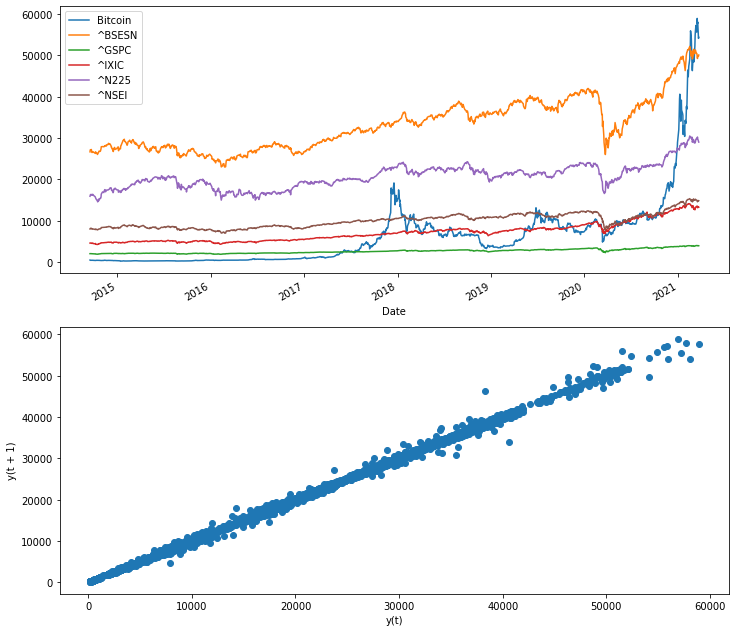

In [38]:
# Plot the time series and lag plot of all the predictors, along with BTC, 
# to determine if their values are random
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols = 1, figsize = (12, 12))
combined.plot(ax = ax1)
pd.plotting.lag_plot(combined)
plt.show()

In [39]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("\n")

In [40]:
# Create the train data set 
X_train = combined.head(int(len(combined) - 7))
X_train

,Bitcoin,^BSESN,^GSPC,^IXIC,^N225,^NSEI
Date,,,,,,
2014-09-17,457.334015,26631.289062,2001.569946,4562.189941,15888.669922,7975.500000
2014-09-18,424.440002,27112.210938,2011.359985,4593.430176,16067.570312,8114.750000
2014-09-19,394.795990,27090.419922,2010.400024,4579.790039,16321.169922,8121.450195
2014-09-22,402.152008,27206.740234,1994.290039,4527.689941,16205.900391,8146.299805
2014-09-24,423.204987,26744.689453,1998.300049,4555.220215,16167.450195,8002.399902
...,...,...,...,...,...,...
2021-03-05,48751.710000,50405.320312,3841.939941,12920.150391,28864.320312,14938.099609
2021-03-08,52375.170000,50441.070312,3821.350098,12609.160156,28743.250000,14956.200195
2021-03-09,54884.500000,51025.480469,3875.439941,13073.820312,29027.939453,15098.400391


In [41]:
# Print the Augmented Dickey-Fuller Test for BTC and all predictors involved
print('Augmented Dickey-Fuller Test: Bitcoin Price Time Series')
augmented_dickey_fuller_statistics(X_train['Bitcoin'])

print('Augmented Dickey-Fuller Test: BSESN Price Time Series')
augmented_dickey_fuller_statistics(X_train['^BSESN'])

print('Augmented Dickey-Fuller Test: N225 Price Time Series')
augmented_dickey_fuller_statistics(X_train['^N225'])

print('Augmented Dickey-Fuller Test: GSPC Price Time Series')
augmented_dickey_fuller_statistics(X_train['^GSPC'])

print('Augmented Dickey-Fuller Test: IXIC Price Time Series')
augmented_dickey_fuller_statistics(X_train['^IXIC'])

print('Augmented Dickey-Fuller Test: NSEI Price Time Series')
augmented_dickey_fuller_statistics(X_train['^NSEI'])

Augmented Dickey-Fuller Test: Bitcoin Price Time Series
ADF Statistic: 4.207013
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: BSESN Price Time Series
ADF Statistic: 0.018911
p-value: 0.960068
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: N225 Price Time Series
ADF Statistic: -0.817593
p-value: 0.813900
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: GSPC Price Time Series
ADF Statistic: 0.317357
p-value: 0.978127
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: IXIC Price Time Series
ADF Statistic: 1.089007
p-value: 0.995122
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: NSEI Price Time Series
ADF Statistic: -0.183195
p-value: 0.940495
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568




'p' values of less than 0.05 are needed to establish that a series is stationary. As seen above, none of the values are less than 0.05. Hence, to make the data stationary, the first difference was calculated.

In [42]:
# Create a copy of the train data set and find the differences between the current and its previous row for every row
X_train = X_train.copy()
X_train_diff =(X_train).diff().dropna()
X_train_diff.describe()

,Bitcoin,^BSESN,^GSPC,^IXIC,^N225,^NSEI
count,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000,1448.000000
mean,39.201924,16.685628,1.341001,6.048115,9.550525,4.872548
std,608.105180,382.054400,32.370222,107.268741,267.360989,112.788008
min,-6531.570000,-2919.257812,-324.890137,-970.290039,-1286.330078,-868.250000
25%,-30.090996,-152.040039,-8.177612,-26.392822,-115.082031,-44.575684
50%,2.319008,24.154297,1.804932,9.219971,13.674805,6.900391
75%,67.532500,211.768066,14.282532,49.447632,143.080078,63.449463
max,8084.630000,2476.261719,230.380127,673.080078,1454.281250,708.400391


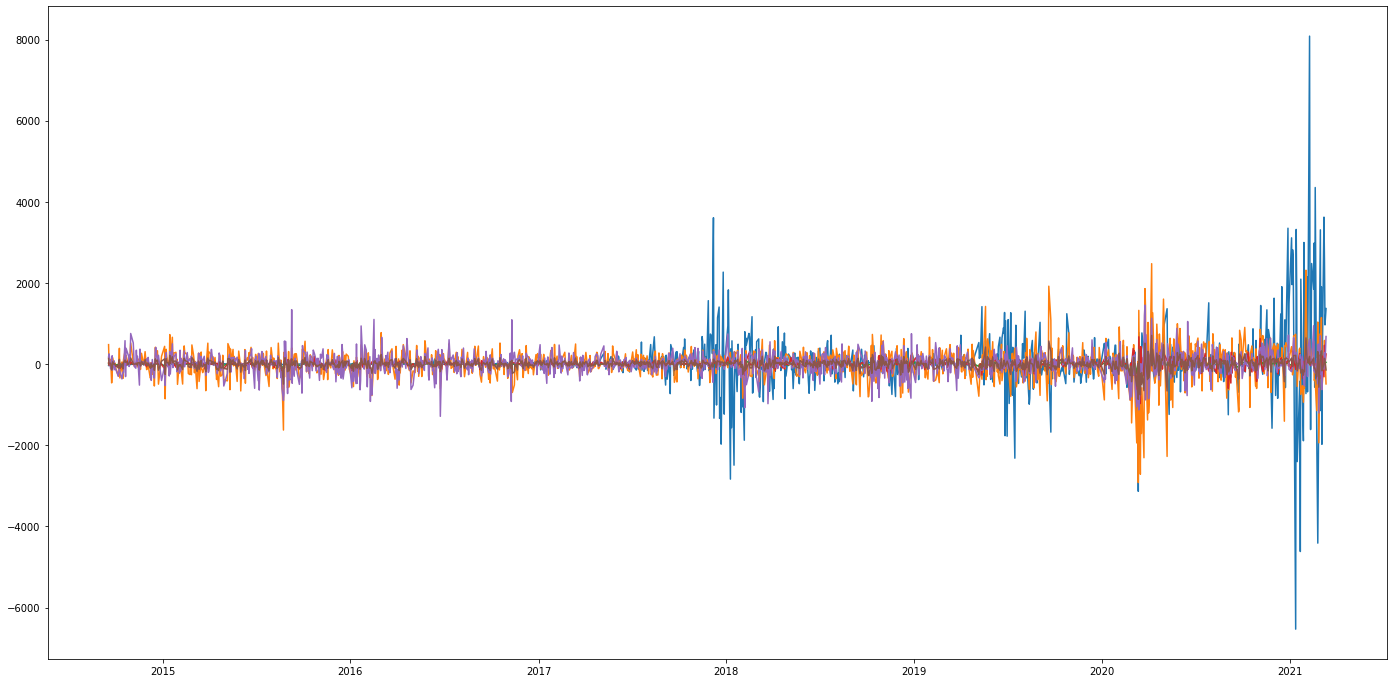

In [45]:
plt.figure(figsize = (24,12))
plt.plot(X_train_diff)

In [46]:
# Print the Augmented Dickey-Fuller Test for BTC and all predictors involved
print('Augmented Dickey-Fuller Test: Bitcoin Price Time Series')
augmented_dickey_fuller_statistics(X_train_diff['Bitcoin'])

print('Augmented Dickey-Fuller Test: BSESN Price Time Series')
augmented_dickey_fuller_statistics(X_train_diff['^BSESN'])

print('Augmented Dickey-Fuller Test: NSEI Price Time Series')
augmented_dickey_fuller_statistics(X_train_diff['^NSEI'])

print('Augmented Dickey-Fuller Test: IXIC Price Time Series')
augmented_dickey_fuller_statistics(X_train_diff['^IXIC'])

print('Augmented Dickey-Fuller Test: GSPC Price Time Series')
augmented_dickey_fuller_statistics(X_train_diff['^GSPC'])

print('Augmented Dickey-Fuller Test: N225 Price Time Series')
augmented_dickey_fuller_statistics(X_train_diff['^N225'])

Augmented Dickey-Fuller Test: Bitcoin Price Time Series
ADF Statistic: -3.877933
p-value: 0.002203
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: BSESN Price Time Series
ADF Statistic: -9.537425
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: NSEI Price Time Series
ADF Statistic: -9.495450
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: IXIC Price Time Series
ADF Statistic: -11.000730
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: GSPC Price Time Series
ADF Statistic: -8.697005
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Augmented Dickey-Fuller Test: N225 Price Time Series
ADF Statistic: -25.064980
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568




All the p-values now are less than 0.05. This implies that all the series now have been converted into stationary series

In [47]:
# Print the Granger Causality test for BTC and the predictors involved
print(grangercausalitytests(X_train_diff[['Bitcoin','^N225']], maxlag=15, 
                            addconst=True, verbose=True))
print(grangercausalitytests(X_train_diff[['Bitcoin','^NSEI']], maxlag=15, 
                            addconst=True, verbose=True))
print(grangercausalitytests(X_train_diff[['Bitcoin','^GSPC']], maxlag=15, 
                            addconst=True, verbose=True))
print(grangercausalitytests(X_train_diff[['Bitcoin','^IXIC']], maxlag=15, 
                            addconst=True, verbose=True))
print(grangercausalitytests(X_train_diff[['Bitcoin','^BSESN']], maxlag=15, 
                            addconst=True, verbose=True))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1280  , p=0.7206  , df_denom=1444, df_num=1
ssr based chi2 test:   chi2=0.1283  , p=0.7202  , df=1
likelihood ratio test: chi2=0.1283  , p=0.7203  , df=1
parameter F test:         F=0.1280  , p=0.7206  , df_denom=1444, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1316  , p=0.8767  , df_denom=1441, df_num=2
ssr based chi2 test:   chi2=0.2640  , p=0.8763  , df=2
likelihood ratio test: chi2=0.2640  , p=0.8763  , df=2
parameter F test:         F=0.1316  , p=0.8767  , df_denom=1441, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2560  , p=0.8571  , df_denom=1438, df_num=3
ssr based chi2 test:   chi2=0.7718  , p=0.8562  , df=3
likelihood ratio test: chi2=0.7716  , p=0.8562  , df=3
parameter F test:         F=0.2560  , p=0.8571  , df_denom=1438, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6183  , p=0.

In [48]:
# Create the test data set
X_test = combined.tail(7)
X_test

,Bitcoin,^BSESN,^GSPC,^IXIC,^N225,^NSEI
Date,,,,,,
2021-03-15,55605.20,50395.078125,3968.939941,13459.709961,29766.970703,14929.500000
2021-03-16,56900.75,50363.960938,3962.709961,13471.570312,29921.089844,14910.450195
2021-03-17,58912.97,49801.621094,3974.120117,13525.200195,29914.330078,14721.299805
2021-03-18,57648.16,49216.519531,3915.459961,13116.169922,30216.750000,14557.849609
2021-03-19,58030.01,49858.238281,3913.100098,13215.240234,29792.050781,14744.000000
2021-03-22,54083.25,49771.289062,3940.590088,13377.540039,29174.150391,14736.400391
2021-03-23,54340.89,50051.441406,3910.520020,13227.700195,28995.919922,14814.750000


In [49]:
# Initiate the VAR model
model = VAR(endog=X_train_diff)
res = model.select_order(15)
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,54.63,54.65,5.328e+23,54.64
1,54.33,54.49*,3.947e+23,54.39
2,54.28,54.57,3.746e+23,54.39
3,54.22,54.64,3.544e+23,54.38*
4,54.22,54.77,3.526e+23,54.43
5,54.19,54.87,3.420e+23,54.44
6,54.19,55.01,3.424e+23,54.49
7,54.18,55.13,3.383e+23,54.53
8,54.15,55.23,3.282e+23,54.55
9,54.15,55.36,3.294e+23,54.60


In [50]:
# Fit to a VAR model
model_fit = model.fit(maxlags=3)
# Print a summary of the model results
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Apr, 2021
Time:                     13:16:30
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    54.6116
Nobs:                     1445.00    HQIC:                   54.3507
Log likelihood:          -51344.4    FPE:                3.44163e+23
AIC:                      54.1954    Det(Omega_mle):     3.18218e+23
--------------------------------------------------------------------
Results for equation Bitcoin
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             33.027319        15.994189            2.065           0.039
L1.Bitcoin         0.023892         0.026562            0.899           0.368
L1.^BSESN          0.398054         0.423188            0.941         

In [51]:
# Get the lag order
lag_order = model_fit.k_ar

# Input data for forecasting
input_data = X_train_diff.values[- lag_order:]

# Forecasting
predicted = model_fit.forecast(y=input_data, steps=7)
predicted = (pd.DataFrame(predicted, index=X_test.index, columns=X_test.columns +'_pred'))


In [52]:
# Inverting transformation
def invert_transformation(X_train, pred_df):
    forecast = predicted.copy()
    columns = X_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = X_train[col].iloc[-1] + forecast[str(col) 
        +'_pred'].cumsum()
    return forecast

output = invert_transformation(X_train, predicted)
print(output)

            Bitcoin_pred   ^BSESN_pred  ...    ^N225_pred    ^NSEI_pred
Date                                    ...                            
2021-03-15  57886.778587  51216.480194  ...  29982.507855  15154.302743
2021-03-16  57821.449031  51410.563381  ...  30108.377418  15210.792169
2021-03-17  58025.773888  51539.430236  ...  30144.444826  15247.732361
2021-03-18  58180.316752  51521.838544  ...  30146.639862  15244.323238
2021-03-19  58246.325608  51553.996860  ...  30145.945337  15253.394092
2021-03-22  58303.686446  51565.615457  ...  30166.175852  15257.489602
2021-03-23  58366.471748  51591.732699  ...  30171.410175  15264.775751

[7 rows x 6 columns]


In [53]:
# Check the predicted BTC values against the actual BTC values
merged = pd.concat([output['Bitcoin_pred'],combined['Bitcoin'].tail(7)], axis = 1)
merged

,Bitcoin_pred,Bitcoin
Date,,
2021-03-15,57886.778587,55605.20
2021-03-16,57821.449031,56900.75
2021-03-17,58025.773888,58912.97
2021-03-18,58180.316752,57648.16
2021-03-19,58246.325608,58030.01
2021-03-22,58303.686446,54083.25
2021-03-23,58366.471748,54340.89


In [54]:
# RMSE of the Multi-Variate Vector AutoRegression
MSE = mean_squared_error(merged['Bitcoin'], merged['Bitcoin_pred'])
VAR_rmse = math.sqrt(MSE)
VAR_rmse

2425.6892969648397

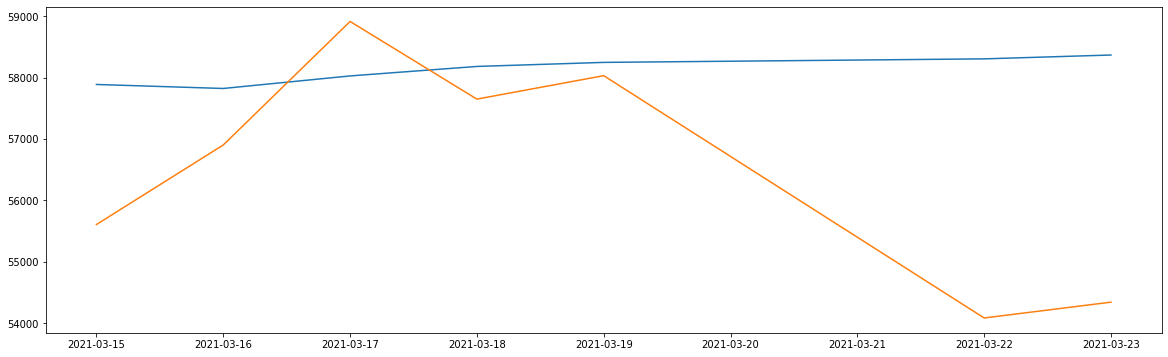

In [55]:
# Plot the Multi-Variate Vector AutoRegression with the actual values of BTC
plt.figure(figsize=(20,6))
plt.plot(merged)

In [56]:
# Printing the accuracy for all the test dates.
accuracy(merged)

Actual Value: $ 57886.77858725814  Predicted Value: $ 55605.2  Accuracy:  96.05854973632898
Actual Value: $ 57821.44903124853  Predicted Value: $ 56900.75  Accuracy:  98.40768599425628
Actual Value: $ 58025.77388752371  Predicted Value: $ 58912.97  Accuracy:  101.52896903054842
Actual Value: $ 58180.31675233638  Predicted Value: $ 57648.16  Accuracy:  99.08533197816423
Actual Value: $ 58246.32560848445  Predicted Value: $ 58030.01  Accuracy:  99.6286193056392
Actual Value: $ 58303.686446009946  Predicted Value: $ 54083.25  Accuracy:  92.76128714447906
Actual Value: $ 58366.47174846299  Predicted Value: $ 54340.89  Accuracy:  93.1029208587223
Average Accuracy over 7 Days:  97.22476629259121


In [57]:
#printing the forcasted error.
RFE(merged)

[2281.57858725814, 920.6990312485286, -887.1961124762893, 532.1567523363774, 216.31560848444497, 4220.436446009946, 4025.581748462988]
Mean Forecast Error: 1615.653152


In [58]:
VAR_pred = merged['Bitcoin_pred'].copy()

In [59]:
VAR_pred

Date
2021-03-15    57886.778587
2021-03-16    57821.449031
2021-03-17    58025.773888
2021-03-18    58180.316752
2021-03-19    58246.325608
2021-03-22    58303.686446
2021-03-23    58366.471748
Name: Bitcoin_pred, dtype: float64

VAR uses past data to predict the next value but that prediction is for the immediate value for the next entry. This was seen when the team tried out different combinations of testing data entries to find that the first value was always predicted very accurately but the next values were not as close. The team decided to use Long Short Term Memory (LSTM), a form of Artificial Neural Netwrok to predict values in a similar way using stock indices. This decision was taken because the overlap of the time series with one another was clearly seen in the tests conducted before developing the Vector Autoregression Model. Also, LSTM uses feedback loops and the data will be provided in a way such that the actual price for bitcoin/ other predictors a day before the test date will always be provided.

## Long short-term memory ANN

### Uni-variate LSTM

In [60]:
# Find the length of the training data for the Univariate LSTM
training_data_len = len(combined) - 7  
training_data_len

1449

In [61]:
# Scale the data for bitcoin
scaler = MinMaxScaler(feature_range=(0,1))
BTC_arr = np.array(combined[['Bitcoin']])
scaled_data = scaler.fit_transform(BTC_arr)
scaled_data

array([[0.00475409],
       [0.00419405],
       [0.00368934],
       ...,
       [0.98496702],
       [0.91777082],
       [0.92215731]])

In [62]:
# Creating the training dataset
training_data = scaled_data[:training_data_len, :]

# Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(30, len(training_data)):
    x_train.append(training_data[i-30:i,0])
    y_train.append(training_data[i, 0])

In [63]:
# Convert x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [64]:
# Reshape the data 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1419, 30, 1)

In [65]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [66]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [73]:
# Train the model
model.fit(x_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 38ms/step - loss: 1.3289e-04
Epoch 2/100
23/23 [==============================] - 1s 35ms/step - loss: 1.3195e-04
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 1.3890e-04
Epoch 4/100
23/23 [==============================] - 1s 36ms/step - loss: 1.9639e-04
Epoch 5/100
23/23 [==============================] - 1s 37ms/step - loss: 1.6060e-04
Epoch 6/100
23/23 [==============================] - 1s 37ms/step - loss: 2.3984e-04
Epoch 7/100
23/23 [==============================] - 1s 36ms/step - loss: 2.0920e-04
Epoch 8/100
23/23 [==============================] - 1s 37ms/step - loss: 1.2199e-04
Epoch 9/100
23/23 [==============================] - 1s 36ms/step - loss: 1.2227e-04
Epoch 10/100
23/23 [==============================] - 1s 38ms/step - loss: 1.2835e-04
Epoch 11/100
23/23 [==============================] - 1s 38ms/step - loss: 1.2883e-04
Epoch 12/100
23/23 [==============================] - 1s 37ms/s

In [74]:
# Create the testing dataset 
test_data = scaled_data[training_data_len - 30:, :]

# Create testing datasets: x_test, y_test
x_test = []
y_test = BTC_arr[training_data_len:,:]

for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i,0])

In [75]:
# Convert data to numpy array 
x_test = np.array(x_test)

In [76]:
# Reshape the data 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

In [77]:
# Get the models predicted price value
predicted = model.predict(x_test)
# Unscaling values to obtain actual values instead of values between [0,1]
predicted = scaler.inverse_transform(predicted) 

In [78]:
# RMSE of the Univariate LSTM
ULSTM_rmse = np.sqrt(np.mean(predicted - y_test)**2)
ULSTM_rmse

417.0938169642853

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


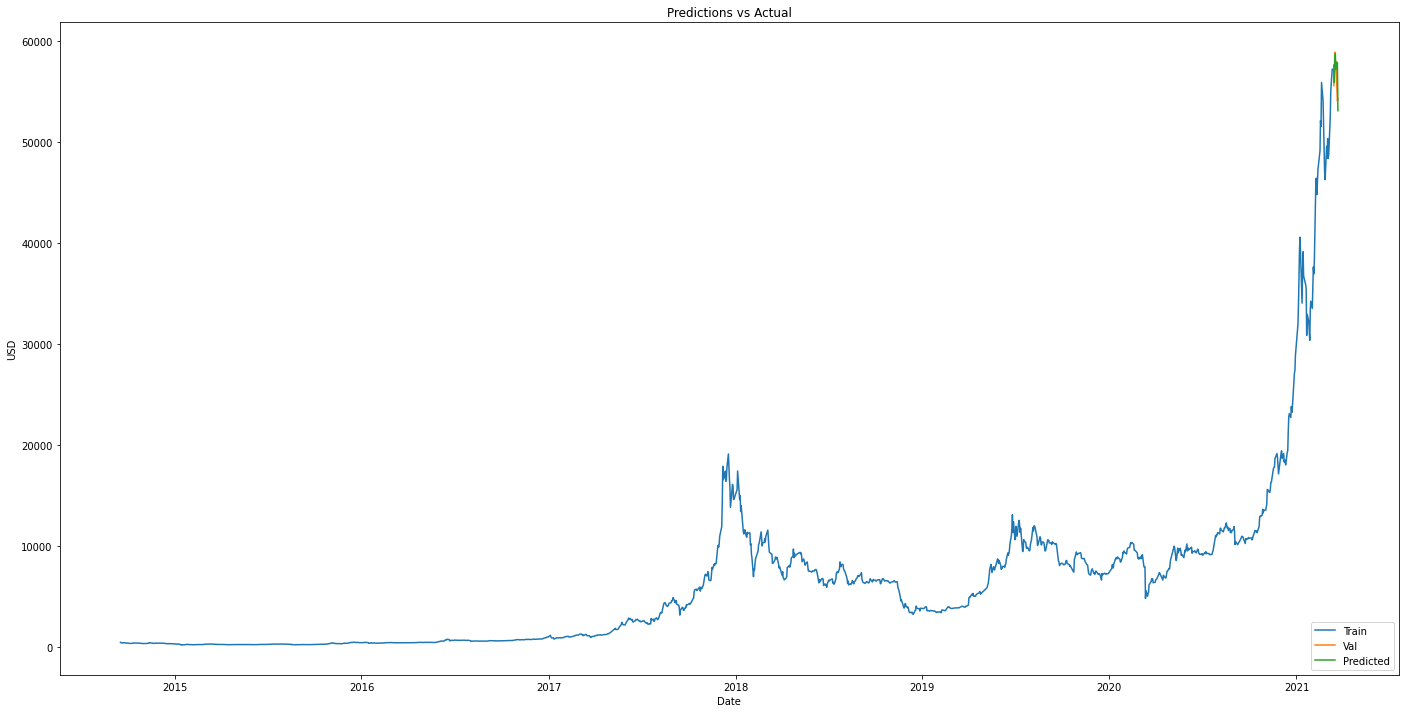

In [79]:
data = combined.filter(['Bitcoin'])
# Plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predicted'] = predicted
# Visualization
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(train['Bitcoin'])
plt.plot(valid[['Bitcoin','Predicted']])
plt.legend(['Train','Val', 'Predicted'], loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


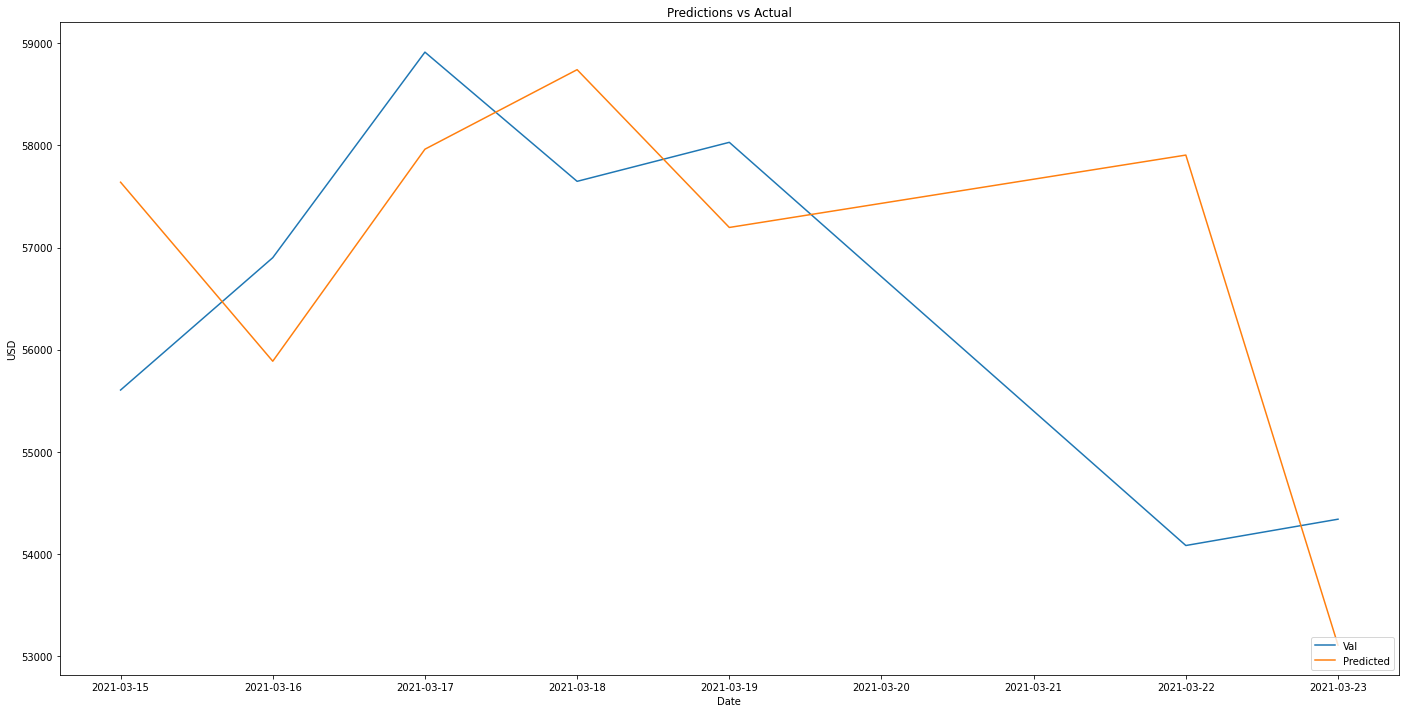

In [80]:
data = combined.filter(['Bitcoin'])
# Plot the data 
valid = data[training_data_len:]
valid['Predicted'] = predicted
# Visualize the data
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(valid[['Bitcoin','Predicted']])
plt.legend(['Val', 'Predicted'], loc = 'lower right')

In [81]:
# Printing the accuracy for all the test dates.
accuracy(valid[['Bitcoin', 'Predicted']])

Actual Value: $ 55605.2  Predicted Value: $ 57639.688  Accuracy:  103.65880798918087
Actual Value: $ 56900.75  Predicted Value: $ 55887.336  Accuracy:  98.21897942909365
Actual Value: $ 58912.97  Predicted Value: $ 57962.75  Accuracy:  98.38707843111627
Actual Value: $ 57648.16  Predicted Value: $ 58741.3  Accuracy:  101.89622839870344
Actual Value: $ 58030.01  Predicted Value: $ 57196.664  Accuracy:  98.56393969689131
Actual Value: $ 54083.25  Predicted Value: $ 57905.242  Accuracy:  107.066868554497
Actual Value: $ 54340.89  Predicted Value: $ 53107.906  Accuracy:  97.7310203237378
Average Accuracy over 7 Days:  100.78898897474575


In [82]:
#printing the forcasted error.
RFE(valid[['Bitcoin', 'Predicted']])

[-2034.487500000003, 1013.4140625, 950.2200000000012, -1093.1407812499965, 833.345937500002, -3821.9921875, 1232.9837499999994]
Mean Forecast Error: -417.093817


In [83]:
ULSTM_pred = valid['Predicted'].copy()

### Multi-variate LSTM

In [84]:
# Using Multi-Variate LSTM
training_data_multi_len = len(combined) - 7 
training_data_multi_len

1449

In [85]:
combined_without_date = combined[['Bitcoin','^BSESN','^GSPC','^IXIC','^N225','^NSEI']]

scaler = MinMaxScaler(feature_range=(0,1))
df_without_date = np.array(combined_without_date)
scaled_data_multi = scaler.fit_transform(df_without_date)
scaled_data_multi

array([[0.00475409, 0.12548982, 0.0705427 , 0.03490555, 0.08510447,
        0.12045043],
       [0.00419405, 0.14200036, 0.07515573, 0.03806813, 0.09633118,
        0.13714137],
       [0.00368934, 0.14125225, 0.0747034 , 0.03668728, 0.11224557,
        0.13794448],
       ...,
       [0.98496702, 0.9228948 , 0.97124762, 0.91089063, 0.95759717,
        0.93174393],
       [0.91777082, 0.91990974, 0.98420079, 0.92732092, 0.91882146,
        0.93083301],
       [0.92215731, 0.92952766, 0.9700319 , 0.912152  , 0.90763678,
        0.94022424]])

In [86]:
# Creating the training dataset
training_data_multi = scaled_data_multi[:training_data_multi_len, :]

# Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(30, len(training_data)):
    x_train.append(training_data_multi[i-30:i,:])
    y_train.append(training_data_multi[i, 0])

In [87]:
# Convert x_train and y_train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [88]:
# Reshape the data 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 6))
x_train.shape

(1419, 30, 6)

In [89]:
# Build the LSTM model
model_multi = Sequential()
model_multi.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 6)))
model_multi.add(LSTM(50, return_sequences=False))
model_multi.add(Dense(25))
model_multi.add(Dense(1))

In [90]:
# Compile the model
model_multi.compile(optimizer='adam', loss='mean_squared_error')

In [109]:
# Train the model
model_multi.fit(x_train, y_train, batch_size=512, epochs=50)

Epoch 1/50
3/3 [==============================] - 0s 160ms/step - loss: 3.2418e-04
Epoch 2/50
3/3 [==============================] - 1s 163ms/step - loss: 3.2392e-04
Epoch 3/50
3/3 [==============================] - 0s 159ms/step - loss: 3.2068e-04
Epoch 4/50
3/3 [==============================] - 0s 155ms/step - loss: 3.1866e-04
Epoch 5/50
3/3 [==============================] - 0s 159ms/step - loss: 3.1862e-04
Epoch 6/50
3/3 [==============================] - 1s 158ms/step - loss: 3.1900e-04
Epoch 7/50
3/3 [==============================] - 1s 161ms/step - loss: 3.1846e-04
Epoch 8/50
3/3 [==============================] - 1s 166ms/step - loss: 3.1929e-04
Epoch 9/50
3/3 [==============================] - 0s 159ms/step - loss: 3.1864e-04
Epoch 10/50
3/3 [==============================] - 1s 166ms/step - loss: 3.1680e-04
Epoch 11/50
3/3 [==============================] - 1s 166ms/step - loss: 3.1656e-04
Epoch 12/50
3/3 [==============================] - 1s 163ms/step - loss: 3.0950e-04
E

In [110]:
# Create the testing dataset 
test_data_multi = scaled_data_multi[training_data_multi_len - 30:, :]

# Create testing datasets: x_test, y_test
x_test = []
y_test = BTC_arr[training_data_multi_len:,:]

for i in range(30, len(test_data_multi)):
    x_test.append(test_data_multi[i-30:i,:])

In [111]:
# Convert data to numpy array 
x_test = np.array(x_test)

In [112]:
# Reshape the data 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 6))

In [113]:
# Get the models predicted price value
predicted_multi = model_multi.predict(x_test)
forecast_multi = np.repeat(predicted_multi, df_without_date.shape[1], axis = -1)
# Unscaling values to obtain actual values instead of values between [0,1]
predicted_multi = scaler.inverse_transform(forecast_multi)[:,0] 

In [114]:
# Getting root mean squared error (RMSE)
MLSTM_rmse = np.sqrt(np.mean(predicted_multi - y_test)**2)
print(MLSTM_rmse)

148.57303571428616


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


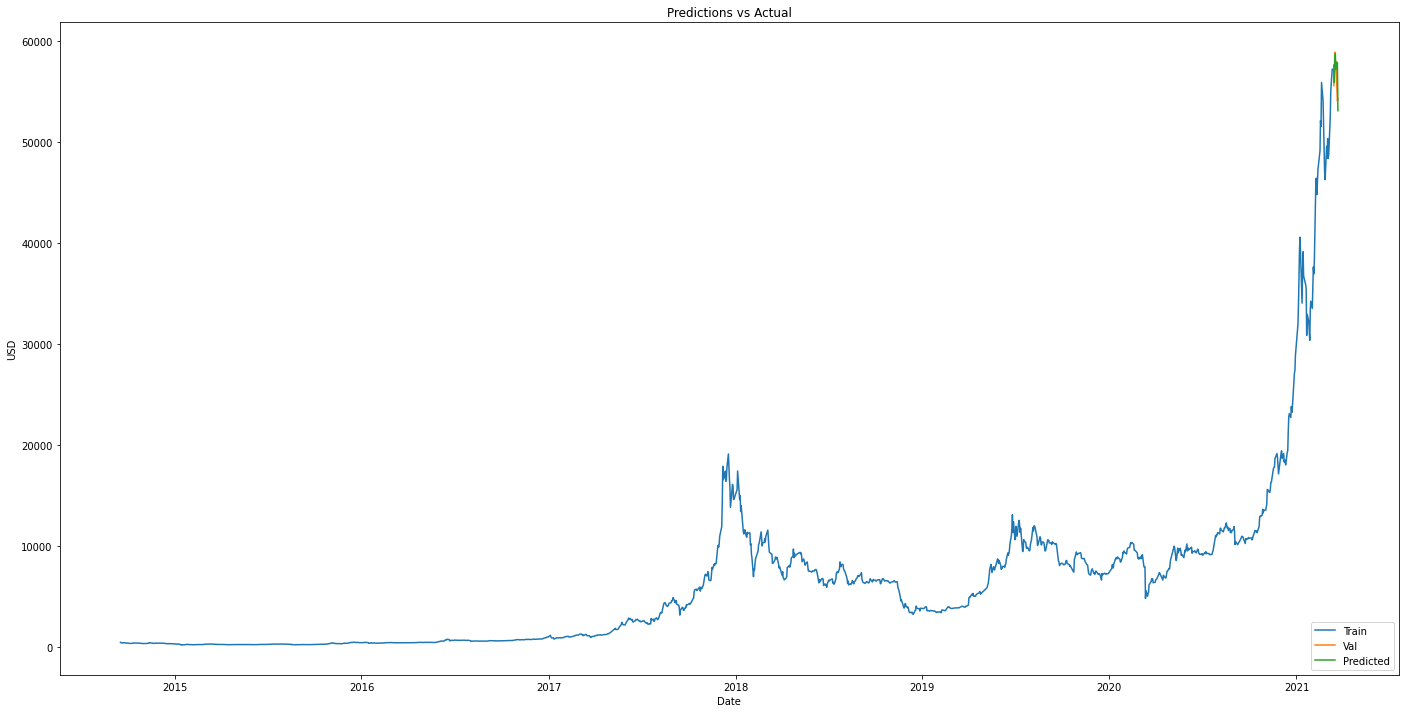

In [115]:
data = combined.filter(['Bitcoin'])
# Plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predicted'] = predicted
# Visualize the data
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(train['Bitcoin'])
plt.plot(valid[['Bitcoin','Predicted']])
plt.legend(['Train','Val', 'Predicted'], loc = 'lower right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


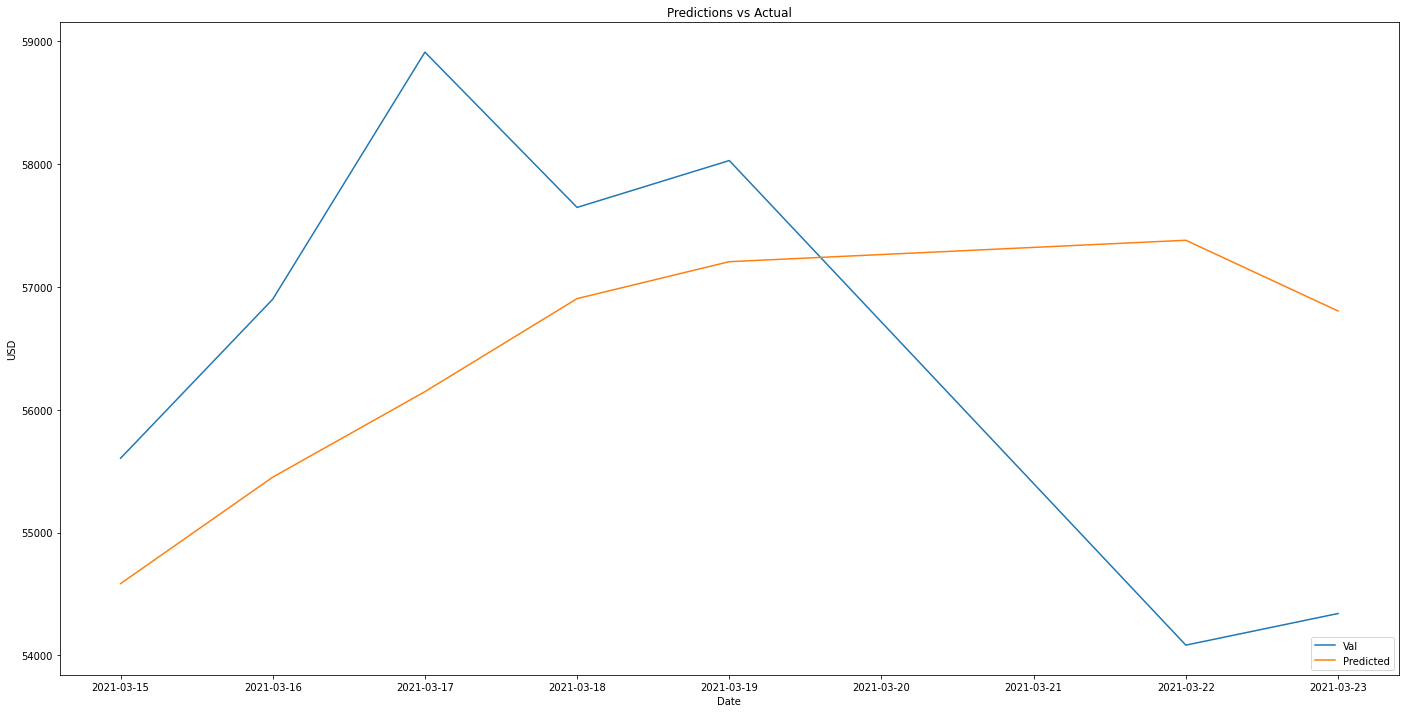

In [116]:
data = combined.filter(['Bitcoin'])
# Plot the data 
valid2 = data[training_data_len:]
valid2['Predicted'] = predicted_multi
# Visualize the data
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(valid2[['Bitcoin','Predicted']])
plt.legend(['Val', 'Predicted'], loc = 'lower right')

In [117]:
# Printing the accuracy for all the test dates.
accuracy(valid2[['Bitcoin', 'Predicted']])

Actual Value: $ 55605.2  Predicted Value: $ 54584.406  Accuracy:  98.16421171041559
Actual Value: $ 56900.75  Predicted Value: $ 55451.484  Accuracy:  97.45299380939618
Actual Value: $ 58912.97  Predicted Value: $ 56147.855  Accuracy:  95.30644180517464
Actual Value: $ 57648.16  Predicted Value: $ 56905.62  Accuracy:  98.71194690992738
Actual Value: $ 58030.01  Predicted Value: $ 57206.344  Accuracy:  98.58062018255727
Actual Value: $ 54083.25  Predicted Value: $ 57380.777  Accuracy:  106.0971323723149
Actual Value: $ 54340.89  Predicted Value: $ 56804.73  Accuracy:  104.53404511547382
Average Accuracy over 7 Days:  99.83534170075141


In [118]:
RFE(valid2[['Bitcoin', 'Predicted']])

[1020.7937499999971, 1449.265625, 2765.114531250001, 742.5389062500035, 823.666250000002, -3297.52734375, -2463.8404687500006]
Mean Forecast Error: 148.573036


In [119]:
MLSTM_pred = valid2['Predicted'].copy()

Comparisons of all the models

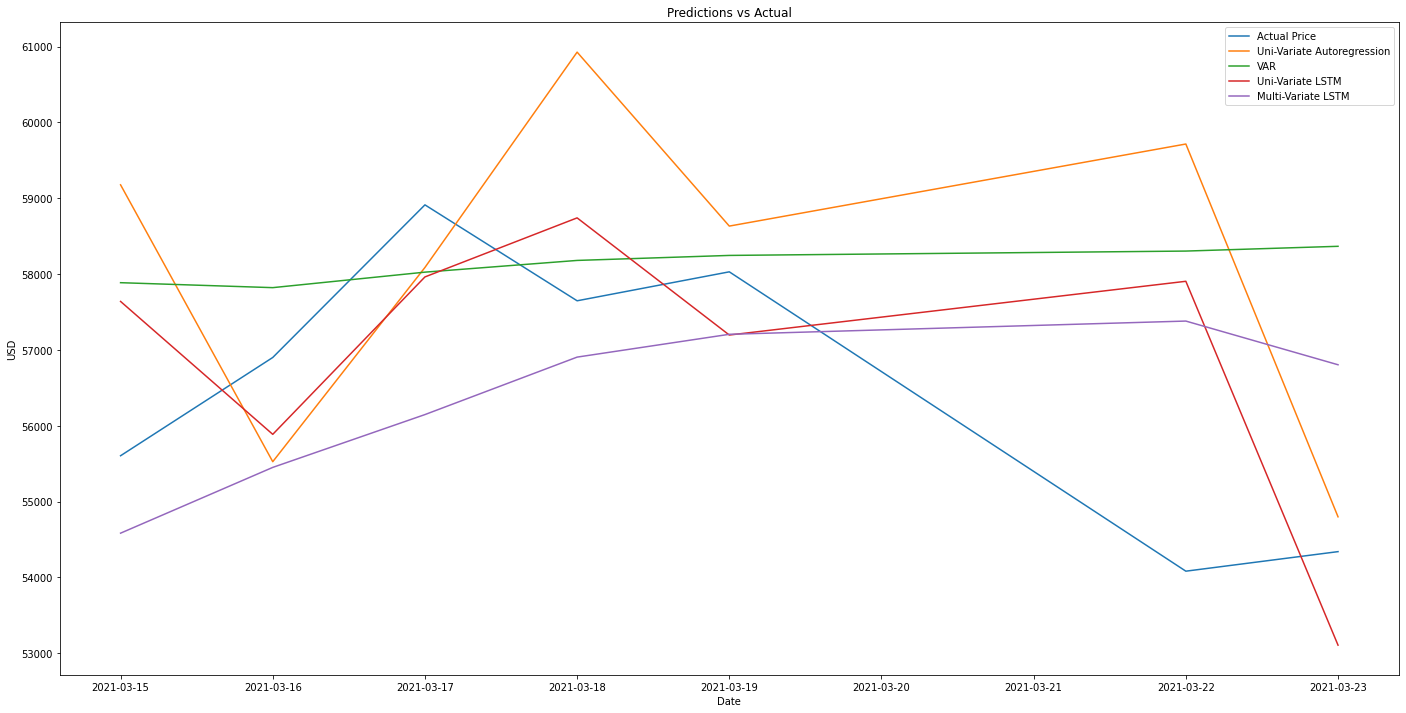

In [120]:
plt.figure(figsize = (24,12))
plt.title('Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('USD')
plt.plot(data[training_data_len:])
plt.plot(UAR_pred)
plt.plot(VAR_pred)
plt.plot(ULSTM_pred)
plt.plot(MLSTM_pred)
plt.legend(['Actual Price','Uni-Variate Autoregression', 'VAR',
            'Uni-Variate LSTM','Multi-Variate LSTM'], loc = 'upper right')

In [121]:
print("All the RMSE: ")
print("Univariate Auto Regression: \t$", UAR_rmse)
print("Multivariate Auto Regression: \t$", VAR_rmse)
print("Uni-Variate LSTM: \t\t$", ULSTM_rmse)
print("Multi-Variate LSTM: \t\t$", MLSTM_rmse)

All the RMSE: 
Univariate Auto Regression: 	$ 2887.6325006673856
Multivariate Auto Regression: 	$ 2425.6892969648397
Uni-Variate LSTM: 		$ 417.0938169642853
Multi-Variate LSTM: 		$ 148.57303571428616


In [122]:
print("Accuracy of all the models: ")
print()
print("\t\t\t\tUnivariate Auto Regression")
accuracy(combined_UAR)
print()
print("\t\t\t\tMultivariate Auto Regression")
accuracy(merged)
print()
print("\t\t\t\tUni-Variate LSTM")
accuracy(valid[['Bitcoin', 'Predicted']])
print()
print("\t\t\t\tMulti-Variate LSTM")
accuracy(valid2[['Bitcoin', 'Predicted']])

Accuracy of all the models: 

				Univariate Auto Regression
Actual Value: $ 55605.2  Predicted Value: $ 59177.147440611436  Accuracy:  106.42376511659239
Actual Value: $ 56900.75  Predicted Value: $ 55526.7975435793  Accuracy:  97.58535264223987
Actual Value: $ 58912.97  Predicted Value: $ 58087.574980603575  Accuracy:  98.59895873625717
Actual Value: $ 57648.16  Predicted Value: $ 60926.6208182039  Accuracy:  105.68701727549308
Actual Value: $ 58030.01  Predicted Value: $ 58633.01445621121  Accuracy:  101.03912519782645
Actual Value: $ 54083.25  Predicted Value: $ 59715.15812162843  Accuracy:  110.41340548437535
Actual Value: $ 54340.89  Predicted Value: $ 54800.03115712002  Accuracy:  100.84492756213604
Average Accuracy over 7 Days:  102.94179314498862

				Multivariate Auto Regression
Actual Value: $ 57886.77858725814  Predicted Value: $ 55605.2  Accuracy:  96.05854973632898
Actual Value: $ 57821.44903124853  Predicted Value: $ 56900.75  Accuracy:  98.40768599425628
Actual Value: $

In [123]:
print("Accuracy of all the models: ")
print()
print("Univariate Auto Regression:")
RFE(combined_UAR)
print()
print("Multivariate Auto Regression:")
RFE(merged)
print()
print("Uni-Variate LSTM:")
RFE(valid[['Bitcoin', 'Predicted']])
print()
print("Multi-Variate LSTM:")
RFE(valid2[['Bitcoin', 'Predicted']])

Accuracy of all the models: 

Univariate Auto Regression:
[-3571.9474406114387, 1373.9524564207022, 825.3950193964265, -3278.4608182038937, -603.0044562112089, -5631.908121628432, -459.1411571200224]
Mean Forecast Error: -1620.730645

Multivariate Auto Regression:
[2281.57858725814, 920.6990312485286, -887.1961124762893, 532.1567523363774, 216.31560848444497, 4220.436446009946, 4025.581748462988]
Mean Forecast Error: 1615.653152

Uni-Variate LSTM:
[-2034.487500000003, 1013.4140625, 950.2200000000012, -1093.1407812499965, 833.345937500002, -3821.9921875, 1232.9837499999994]
Mean Forecast Error: -417.093817

Multi-Variate LSTM:
[1020.7937499999971, 1449.265625, 2765.114531250001, 742.5389062500035, 823.666250000002, -3297.52734375, -2463.8404687500006]
Mean Forecast Error: 148.573036
